In [28]:
import numpy as np
import scipy.stats
import json
from collections import defaultdict
from scipy import spatial
import matplotlib.pyplot as plt
from collections import Counter
from validate_semantics import load_wordnet_axes, get_glove_vecs
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import StandardScaler
from scipy.stats import mannwhitneyu
from sklearn.metrics.pairwise import cosine_similarity
import random

In [29]:
ROOT = '/mnt/data0/lucy/manosphere/'
DATA = ROOT + 'data/'
GLOVE = DATA + 'glove/'
LOGS = ROOT + 'logs/'

### Axes in vector space

In [3]:
axes, axes_vocab = load_wordnet_axes()
glove_vecs = get_glove_vecs(set(), axes_vocab, exp_name='default')

In [4]:
def show_top_axes(path, scores):
    with open(path, 'r') as infile:
        biases = json.load(infile) # {c : { pole : (bias, effect) } }

    for c in biases: 
        print("**** BIAS ****", c)
        vals = []
        dims = []
        for pole in biases[c]: 
            bias_sep, p_val, effect, b_t_f1, b_t_f2 = biases[c][pole]
            # separability + statistical significance
            if scores[pole + '_left'][0] >= 0 and scores[pole + '_right'][0] >= 0 and p_val < 0.05:
                dims.append((pole, round(b_t_f2, 3)))
                vals.append(abs(effect))
        sorted_dims = [x for _,x in sorted(zip(vals,dims))]
        for i in range(1, 6): 
            pole, bias = sorted_dims[-i]
            left, right = axes[pole]
            bias_sep, p_val, effect, b_t_f1, b_t_f2 = biases[c][pole]
            if b_t_f2 > 0 and effect > 0: 
                this_side = left
                degree = 'more'
            elif b_t_f2 > 0 and effect <= 0: 
                this_side = left
                degree = 'less'
            elif b_t_f2 <= 0 and effect > 0: 
                this_side = right
                degree = 'less'
            elif b_t_f2 <= 0 and effect <= 0: 
                this_side = right
                degree = 'more'
            print(round(effect, 3), bias, pole, degree.upper(), '(' + ', '.join(this_side)  + ')')
        print()

In [5]:
def get_occ_sent_counts(): 
    with open(DATA + 'semantics/occupation_sents.json', 'r') as infile: 
        occ_sents = json.load(infile)
    with open(DATA + 'semantics/cleaned/occupations.json', 'r') as infile: 
        lexicon_dict = json.load(infile)
    occ_cat = defaultdict(list)
    for c in lexicon_dict: 
        for occ in lexicon_dict[c]['high']: 
            occ_cat[occ].append(c)
    occ_cat_counts = defaultdict(Counter)
    for occ in occ_sents: 
        for cat in occ_cat[occ]: 
            occ_cat_counts[cat][occ] = len(occ_sents[occ])
    for cat in occ_cat_counts: 
        print(cat.upper())
        print(len(occ_cat_counts[cat]))
        for tup in occ_cat_counts[cat].most_common(): 
            print('\t', tup[0], tup[1])

In [6]:
get_occ_sent_counts()

GOVERNMENT
47
	 mayor 127
	 ombudsman 98
	 governor 56
	 aide-de-camp 44
	 sheriff 32
	 ambassador 28
	 prosecutor 26
	 fence viewer 22
	 acting governor 22
	 official 19
	 alderman 17
	 permanent secretary 15
	 city manager 10
	 attaché 10
	 sovereign 9
	 city attorney 9
	 deputy mayor 8
	 advocate general 8
	 drain commissioner 8
	 undersecretary 7
	 postmaster 6
	 royal secretary 6
	 gold commissioner 6
	 treasurer 5
	 municipal commissioner 5
	 press secretary 4
	 state architect 4
	 appraiser 4
	 county administrator 4
	 tax collector 3
	 courtier 3
	 cultural attaché 3
	 permanent representative 3
	 intelligence officer 3
	 county surveyor 2
	 council architect 2
	 village accountant 2
	 cabinet secretary 2
	 hardship post 2
	 acting president 2
	 bureaucrat 2
	 language commissioner 1
	 pursuivant 1
	 county executive 1
	 sub-divisional magistrate 1
	 municipal clerk 1
	 postal worker 1
HEALTH
47
	 midwife 44
	 pharmacist 32
	 psychologist 29
	 pharmacy technician 24
	 dental as

### Occupation and self-consistency evaluation

In [36]:
def mean_confidence_interval(data, confidence=0.90):
    '''
    copied from https://stackoverflow.com/questions/15033511/compute-a-confidence-interval-from-sample-data
    '''
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h

def plot_axes_quality(exp_name, do_plot=True): 
    quality_file_path = LOGS + 'semantics_val/axes_quality_' + exp_name + '.txt'
    scores = defaultdict(dict) # {synset: {word : (predicted, true)}}
    with open(quality_file_path, 'r') as infile: 
        for line in infile: 
            contents = line.strip().split('\t')
            scores[contents[0]][contents[1]] = (float(contents[2]), contents[3])
    avg_scores = Counter()
    ci_scores = Counter()
    good_count = 0
    for synset in scores: 
        left_scores = []
        right_scores = []
        for w in scores[synset]: 
            if scores[synset][w][1] == 'left': 
                left_scores.append(-1*scores[synset][w][0])
            else: 
                right_scores.append(scores[synset][w][0])
        if left_scores != []: 
            # some are empty since they only had one word with reps
            avg_scores[synset + '_left'] = np.mean(left_scores) 
            ci_scores[synset + '_left'] = mean_confidence_interval(left_scores)
        if right_scores != []: 
            avg_scores[synset + '_right'] = np.mean(right_scores) 
            ci_scores[synset + '_right'] = mean_confidence_interval(right_scores)
        if avg_scores[synset + '_left'] >= 0 and avg_scores[synset + '_right'] >= 0: 
            good_count += 1
    ordered_scores = avg_scores.most_common()
    avg_sim = np.mean(list(avg_scores.values()))
    if do_plot: 
        print("BEST", ordered_scores[:10])
        print("WORST", ordered_scores[::-1][:10])
        print("AVG SIMILARITY TO CORRECT SIDE:", avg_sim)
        print("STANDARD DEVIATION:", np.std(list(avg_scores.values())))
        print("GOOD AXES COUNT:", good_count)
        plt.hist(avg_scores.values(), density=True, bins=20)
        plt.axvline(x=np.mean(list(avg_scores.values())), color='red')
        plt.ylabel('frequency')
        plt.xlabel('similarity to correct side')
        plt.title(exp_name)
        plt.show()
    return ci_scores, avg_sim, good_count

BEST [('cardinal.a.02_right', 0.46587843275706514), ('democratic.a.01_right', 0.45688202820996093), ('established.a.01_right', 0.4457313786380787), ('proved.a.01_right', 0.4400854343410742), ('diligent.a.02_left', 0.4298208091532249), ('used.a.01_left', 0.42174856144216466), ('prospective.a.01_left', 0.4127038229058156), ('partial.a.02_right', 0.3980450580154516), ('nourished.a.01_right', 0.3915070398937059), ('all.a.01_left', 0.3797426857709725)]
WORST [('leeward.a.01_left', -0.2969628124826152), ('left-handed.a.01_left', -0.27629508544904546), ('east.a.01_right', -0.2724861278640515), ('alkaline.a.01_left', -0.2609350143981471), ('western.a.02_left', -0.2469994684001294), ('right-handed.a.01_right', -0.22041623298552349), ('same.a.01_left', -0.21482705170077418), ('left-handed.a.01_right', -0.1928498721136952), ('right.a.01_right', -0.1880249658281328), ('like.a.01_left', -0.18562359995196703)]
AVG SIMILARITY TO CORRECT SIDE: 0.10148170209867674
STANDARD DEVIATION: 0.1126810881944173

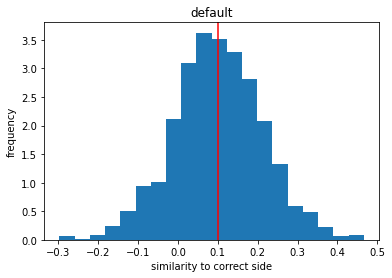

In [8]:
# GloVe 
scores1, _, _ = plot_axes_quality('default')

In [9]:
show_top_axes(LOGS + 'semantics_val/occupations/frameaxis_default.json', scores1)

**** BIAS **** Writing
0.092 0.084 complimentary.a.01 MORE (complimentary, eulogistic, laudatory, panegyric, praising)
0.092 0.141 substantial.a.03 MORE (material, real, substantial)
0.089 0.178 original.a.03 MORE (avant-garde, daring, freehand, fresh, germinal, groundbreaking, innovative, new, newfangled, novel, original, seminal)
0.084 0.128 real.a.01 MORE (actual, documentary, existent, factual, historical, objective, real)
-0.08 -0.08 reverent.a.01 MORE (blasphemous, disrespectful, irreverent, profane, sacrilegious)

**** BIAS **** Theater, film, TV, entertainment
0.108 0.157 healthy.a.01 MORE (bouncing, firm, florid, flushed, full-blooded, good, hale, healthy, hearty, lusty, rosy, ruddy, sanguine, sound, well-preserved, whole, wholesome)
0.107 0.16 sound.a.03 MORE (solid, sound, strong, substantial)
0.105 0.167 colorful.a.01 MORE (ablaze, bright, brilliant, changeable, colorful, colourful, deep, fluorescent, iridescent, prismatic, psychedelic, rich, shot, shrill, vibrant, vivid)
0

BEST [('cosmopolitan.a.02_left', 0.4688037444572688), ('established.a.01_right', 0.4596850064984086), ('diligent.a.02_left', 0.44453673857165804), ('perfect.a.01_right', 0.4236236618175155), ('democratic.a.01_right', 0.42250865007703964), ('coastal.a.02_left', 0.4197461159100794), ('rural.a.01_right', 0.404912632665243), ('loyal.a.01_right', 0.40454635135829137), ('proved.a.01_right', 0.4010928313641157), ('accordant.a.01_right', 0.3786686542925012)]
WORST [('right.a.07_right', -0.24983714360112655), ('middle-class.a.01_right', -0.21872887699865978), ('lower-class.a.01_right', -0.2060201658683339), ('left-handed.a.01_left', -0.2055182739316395), ('carnivorous.a.02_left', -0.20271160378624717), ('bidirectional.a.01_right', -0.2004641383563981), ('simple.a.06_right', -0.18363307685494304), ('plausible.a.01_left', -0.18247291968936494), ('upper-class.a.01_left', -0.18238383433328156), ('right-handed.a.01_right', -0.16924812978017423)]
AVG SIMILARITY TO CORRECT SIDE: 0.08362568852321235
ST

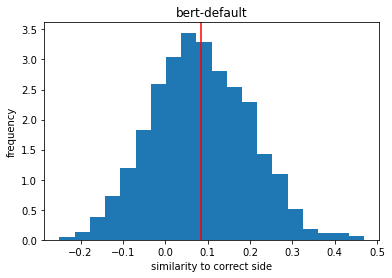

In [10]:
scores2, _, _ = plot_axes_quality('bert-default')

In [11]:
show_top_axes(LOGS + 'semantics_val/occupations/frameaxis_bert-default.json', scores2)

**** BIAS **** Writing
0.07 0.16 creative.a.01 MORE (creative, fanciful, fictive, imaginative, inventive, notional, yeasty)
0.061 0.138 high.a.04 MORE (adenoidal, altissimo, alto, countertenor, falsetto, high, high-pitched, nasal, peaky, pinched, screechy, sharp, shrill, sopranino, soprano, spiky, squeaking, squeaky, squealing, tenor, treble)
0.057 0.12 controversial.a.01 MORE (arguable, contentious, controversial, debatable, disputable, disputed, moot, polemic, polemical)
0.056 0.079 healthy.a.01 MORE (bouncing, firm, florid, flushed, full-blooded, good, hale, healthy, hearty, lusty, rosy, ruddy, sanguine, sound, well-preserved, whole, wholesome)
-0.055 -0.11 fatty.a.01 MORE (fat-free, light, lite, nonfat, skim, skimmed)

**** BIAS **** Theater, film, TV, entertainment
0.066 0.145 ready.a.01 MORE (fit, primed, prompt, ready, ripe, set, waiting)
0.059 0.081 healthy.a.01 MORE (bouncing, firm, florid, flushed, full-blooded, good, hale, healthy, hearty, lusty, rosy, ruddy, sanguine, sound

In [12]:
show_top_axes(LOGS + 'semantics_val/person/frameaxis_bert-default.json', scores2)

**** BIAS **** Writing
-0.018 -0.096 pious.a.01 MORE (godless, impious, irreverent)
-0.018 -0.112 armed.a.01 MORE (barehanded, clean, defenceless, defenseless, unarmed, weaponless)
-0.017 -0.046 holy.a.01 MORE (profane, unconsecrated, unholy)
-0.017 -0.042 consecrated.a.01 MORE (deconsecrated, desecrated, profaned, violated)
-0.017 -0.004 authorized.a.01 MORE (self-appointed, unaccredited, unauthorised, unauthorized, unlicenced, unlicensed)

**** BIAS **** Theater, film, TV, entertainment
0.026 0.091 employed.a.01 MORE (employed, engaged, hired, working)
0.023 0.198 susceptible.a.01 MORE (allergic, amenable, capable, hypersensitive, liable, nonresistant, open, persuadable, pliable, predisposed, sensitised, sensitized, subject, suggestible, supersensitive, susceptible, tractable, unvaccinated, vulnerable)
0.019 0.089 assisted.a.01 MORE (aided, assisted, power-assisted)
-0.018 -0.001 dominant.a.01 MORE (adjunct, assistant, associate, low-level, secondary, subordinate, under)
0.018 0.056 

BEST [('established.a.01_right', 0.7294871953224412), ('proved.a.01_right', 0.6003769027690024), ('coastal.a.02_left', 0.534377121387999), ('diligent.a.02_left', 0.516783715891913), ('metallic.a.01_right', 0.49643004925960144), ('democratic.a.01_right', 0.48636240376103274), ('shod.a.01_right', 0.4850944448444688), ('plowed.a.01_left', 0.4707722675369253), ('rural.a.01_right', 0.46622151722676325), ('simple.a.06_left', 0.46490348156035904)]
WORST [('right.a.07_right', -0.3167768528796098), ('simple.a.06_right', -0.2753792586020164), ('bidirectional.a.01_right', -0.26510131944057097), ('lower-class.a.01_right', -0.23113754876505607), ('digestible.a.01_left', -0.2310606702300178), ('right-handed.a.01_right', -0.22672592475482176), ('carnivorous.a.02_left', -0.22394346918759292), ('alkaline.a.01_left', -0.21794843798810126), ('right.a.01_right', -0.2162411538762183), ('middle-class.a.01_right', -0.20458877321276514)]
AVG SIMILARITY TO CORRECT SIDE: 0.11119279037123038
STANDARD DEVIATION: 

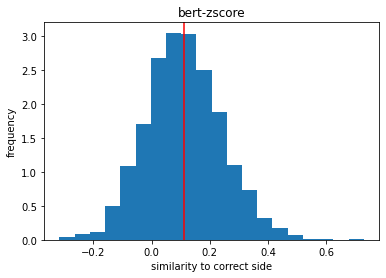

In [13]:
scores3, _, _ = plot_axes_quality('bert-zscore')

In [14]:
show_top_axes(LOGS + 'semantics_val/occupations/frameaxis_bert-zscore.json', scores3)

**** BIAS **** Writing
0.084 0.147 creative.a.01 MORE (creative, fanciful, fictive, imaginative, inventive, notional, yeasty)
-0.056 -0.11 tough.a.07 MORE (chewable, crisp, crispy, flakey, flaky, tender, tenderized)
0.055 0.081 controversial.a.01 MORE (arguable, contentious, controversial, debatable, disputable, disputed, moot, polemic, polemical)
0.055 0.06 persuasive.a.01 MORE (coaxing, cogent, compelling, glib, persuasive, telling, weighty)
0.054 0.059 lengthwise.a.01 MORE (axial, end-to-end, fore-and-aft, lengthwise, linear, longitudinal, running)

**** BIAS **** Theater, film, TV, entertainment
0.06 0.06 major.a.01 MORE (leading, major, prima, star, starring, stellar)
0.059 0.042 healthy.a.01 MORE (bouncing, firm, florid, flushed, full-blooded, good, hale, healthy, hearty, lusty, rosy, ruddy, sanguine, sound, well-preserved, whole, wholesome)
-0.057 -0.051 essential.a.02 MORE (incidental, inessential, nonessential, unessential)
0.055 0.028 corrupt.a.01 MORE (corrupt, corrupted, co

In [15]:
show_top_axes(LOGS + 'semantics_val/person/frameaxis_bert-zscore.json', scores3)

**** BIAS **** Writing
-0.026 -0.086 used.a.01 MORE (abused, exploited, misused, put-upon, used, victimised, victimized)
-0.025 -0.014 dignified.a.01 MORE (demeaning, humbling, humiliating, mortifying, pathetic, ridiculous, silly, undignified)
0.024 0.055 corrupt.a.01 MORE (corrupt, corrupted, corruptible, debased, depraved, dirty, dishonest, perverse, perverted, purchasable, putrid, reprobate, sold-out, sordid, venal, vitiated)
-0.024 -0.005 authorized.a.01 MORE (self-appointed, unaccredited, unauthorised, unauthorized, unlicenced, unlicensed)
-0.023 -0.072 armed.a.01 MORE (barehanded, clean, defenceless, defenseless, unarmed, weaponless)

**** BIAS **** Theater, film, TV, entertainment
0.033 0.034 employed.a.01 MORE (employed, engaged, hired, working)
0.024 0.029 assisted.a.01 MORE (aided, assisted, power-assisted)
-0.023 0.055 corrigible.a.01 LESS (amendable, correctable, redeemable)
0.023 0.032 persuasive.a.01 MORE (coaxing, cogent, compelling, glib, persuasive, telling, weighty)
0

BEST [('rural.a.01_right', 0.5371181252114037), ('supported.a.01_left', 0.5040856690087702), ('neutral.a.04_left', 0.47587807749986166), ('diligent.a.02_left', 0.45958274995518006), ('free.a.02_right', 0.4336422006982699), ('established.a.01_right', 0.43126933621414615), ('homemade.a.01_right', 0.42733535843620685), ('democratic.a.01_right', 0.4264018471855844), ('coastal.a.02_left', 0.4242536194558463), ('perfect.a.01_right', 0.4202335656981863)]
WORST [('leeward.a.01_left', -0.42012955740430175), ('middle-class.a.01_right', -0.22754659959507512), ('fast.a.03_left', -0.22542726008944466), ('left-handed.a.01_right', -0.21669846887523686), ('binaural.a.01_left', -0.20629684800496265), ('carnivorous.a.02_left', -0.20271160378624717), ('bidirectional.a.01_right', -0.2004641383563981), ('perpendicular.a.01_right', -0.19611264658104136), ('conclusive.a.01_right', -0.19302777372791305), ('right-handed.a.01_left', -0.18531544033722547)]
AVG SIMILARITY TO CORRECT SIDE: 0.10135513081180124
STAN

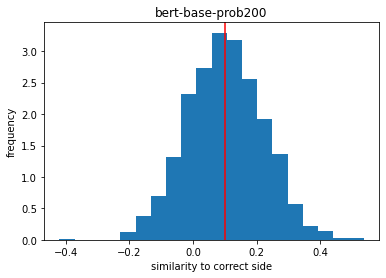

In [41]:
scores7, _, _ = plot_axes_quality('bert-base-prob200')

In [42]:
show_top_axes(LOGS + 'semantics_val/occupations/frameaxis_bert-base-prob200.json', scores7)

**** BIAS **** Writing
-0.076 -0.157 fatty.a.01 MORE (fat-free, light, lite, nonfat, skim, skimmed)
0.068 0.097 healthy.a.01 MORE (bouncing, firm, florid, flushed, full-blooded, good, hale, healthy, hearty, lusty, rosy, ruddy, sanguine, sound, well-preserved, whole, wholesome)
-0.067 -0.075 nonproprietary.a.01 MORE (branded, copyrighted, patented, proprietary, trademarked)
0.066 0.087 middle.a.04 MORE (intervening, mid, middle)
-0.064 -0.08 early.a.01 MORE (advanced, after-hours, intervening, late, mid, middle, posthumous, ripe)

**** BIAS **** Theater, film, TV, entertainment
0.067 0.078 emotional.a.02 MORE (affective, bathetic, cathartic, charged, drippy, emotional, emotive, funky, hokey, hot-blooded, kitschy, little, low-down, lyric, lyrical, maudlin, mawkish, mind-blowing, moody, mushy, releasing, schmaltzy, sentimental, sloppy, slushy, soppy, soulful, soupy, supercharged, temperamental)
0.067 0.16 ready.a.01 MORE (fit, primed, prompt, ready, ripe, set, waiting)
0.06 0.083 middle.a

In [43]:
show_top_axes(LOGS + 'semantics_val/person/frameaxis_bert-base-prob200.json', scores7)

**** BIAS **** Writing
-0.024 -0.081 noble.a.02 MORE (base, common, humble, ignoble, lowly, plebeian, untitled, unwashed, vulgar)
-0.023 -0.005 authorized.a.01 MORE (self-appointed, unaccredited, unauthorised, unauthorized, unlicenced, unlicensed)
-0.02 0.028 prepared.a.01 LESS (braced, embattled, equipped, preconditioned, precooked, prepared, processed, ready, spread, up)
-0.02 -0.126 armed.a.01 MORE (barehanded, clean, defenceless, defenseless, unarmed, weaponless)
-0.019 -0.039 obedient.a.01 MORE (contrary, disobedient, fractious, headstrong, obstinate, perverse, recalcitrant, recusant, refractory, wayward, wilful, willful)

**** BIAS **** Theater, film, TV, entertainment
-0.022 -0.041 nonproprietary.a.01 MORE (branded, copyrighted, patented, proprietary, trademarked)
0.022 0.157 susceptible.a.01 MORE (allergic, amenable, capable, hypersensitive, liable, nonresistant, open, persuadable, pliable, predisposed, sensitised, sensitized, subject, suggestible, supersensitive, susceptible, 

BEST [('supported.a.01_left', 0.7120823325697412), ('established.a.01_right', 0.6980838209207695), ('rural.a.01_right', 0.6457451052592182), ('free.a.02_right', 0.5944080500401777), ('neutral.a.04_left', 0.5835270746021644), ('coastal.a.02_left', 0.5108251149057451), ('enclosed.a.01_right', 0.5105652399555616), ('diligent.a.02_left', 0.5091991132363664), ('cooked.a.01_left', 0.5059098968688065), ('competent.a.01_right', 0.5038614967491493)]
WORST [('leeward.a.01_left', -0.4568135058282691), ('analytic.a.03_left', -0.28663610452800337), ('fast.a.03_left', -0.2777995222467326), ('bidirectional.a.01_right', -0.26510131944057097), ('binaural.a.01_left', -0.24590651461489674), ('right.a.01_right', -0.23997345871973044), ('right-handed.a.01_right', -0.2318553123338481), ('carnivorous.a.02_left', -0.22394346918759292), ('left-handed.a.01_right', -0.22320249278774468), ('middle-class.a.01_right', -0.2165158061174315)]
AVG SIMILARITY TO CORRECT SIDE: 0.1332082864729245
STANDARD DEVIATION: 0.137

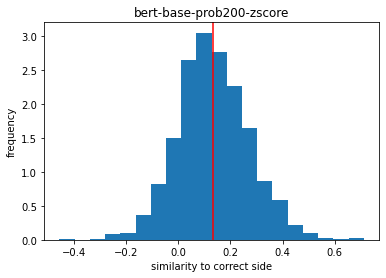

In [44]:
scores8, _, _ = plot_axes_quality('bert-base-prob200-zscore')

In [45]:
show_top_axes(LOGS + 'semantics_val/occupations/frameaxis_bert-base-prob200-zscore.json', scores8)

**** BIAS **** Writing
-0.076 -0.098 nonproprietary.a.01 MORE (branded, copyrighted, patented, proprietary, trademarked)
-0.069 -0.009 noble.a.02 MORE (base, common, humble, ignoble, lowly, plebeian, untitled, unwashed, vulgar)
0.058 0.159 creative.a.01 MORE (creative, fanciful, fictive, imaginative, inventive, notional, yeasty)
-0.057 -0.008 exciting.a.01 MORE (commonplace, humdrum, prosaic, tame, unexciting, unglamorous, uninspired)
0.055 -0.011 healthy.a.01 LESS (angry, arthritic, asthmatic, bad, bloodshot, colicky, creaky, dehydrated, diseased, enlarged, flatulent, foaming, foamy, frothing, gangrenous, gassy, inflamed, inflammatory, ingrown, jaundiced, membranous, mental, morbid, mortified, pathologic, pathological, pro-inflammatory, proinflammatory, puffy, rheumatic, rheumatoid, rheumy, sallow, sickly, sunburned, sunburnt, tumescent, turgid, ulcerated, unfit, unhealthy, unsound, varicose, wheezing, wheezy, yellow)

**** BIAS **** Theater, film, TV, entertainment
0.068 0.108 major.

In [46]:
show_top_axes(LOGS + 'semantics_val/person/frameaxis_bert-base-prob200-zscore.json', scores8)

**** BIAS **** Writing
-0.041 -0.191 formal.a.01 MORE (casual, daily, everyday, folksy, informal, unceremonious)
-0.03 -0.04 noble.a.02 MORE (base, common, humble, ignoble, lowly, plebeian, untitled, unwashed, vulgar)
-0.029 0.015 authorized.a.01 LESS (accredited, approved, authorised, authorized, canonised, canonized, commissioned, empowered, glorified, licenced, licensed, sanctioned)
-0.029 -0.094 used.a.01 MORE (abused, exploited, misused, put-upon, used, victimised, victimized)
-0.027 0.026 prepared.a.01 LESS (braced, embattled, equipped, preconditioned, precooked, prepared, processed, ready, spread, up)

**** BIAS **** Theater, film, TV, entertainment
0.027 0.033 emotional.a.02 MORE (affective, bathetic, cathartic, charged, drippy, emotional, emotive, funky, hokey, hot-blooded, kitschy, little, low-down, lyric, lyrical, maudlin, mawkish, mind-blowing, moody, mushy, releasing, schmaltzy, sentimental, sloppy, slushy, soppy, soulful, soupy, supercharged, temperamental)
-0.027 -0.059 

In [23]:
# U-tests
# z-scored bert prob vs. glove
print(mannwhitneyu(list(scores8.values()), list(scores1.values())))
# z-scored bert prob vs. z-scored bert random
print(mannwhitneyu(list(scores8.values()), list(scores3.values())))
# z-scored bert random vs. glove
print(mannwhitneyu(list(scores3.values()), list(scores1.values())))

MannwhitneyuResult(statistic=-3585197.0, pvalue=0.0)
MannwhitneyuResult(statistic=-3485682.0, pvalue=0.0)
MannwhitneyuResult(statistic=-3214552.0, pvalue=0.0)


# Human evaluation task materials

This section includes metadata used to design the evaluation task, including: 
- example occupations in each category 
- example sentences for each occupation category (taking the first sentence on their page)

In [24]:
with open(DATA + 'semantics/cleaned/occupations.json', 'r') as infile:
    classes = json.load(infile)
with open(DATA + 'semantics/occupation_sents.json', 'r') as infile: 
    occ_sents = json.load(infile)

In [25]:
random.seed(10)
for c in classes: 
    occ_list = [i for i in classes[c]['high'] if i in occ_sents]
    if len(occ_list) > 5: 
        print(', '.join(random.sample(occ_list, 5)))
    else: 
        print(', '.join(occ_list))
    print()

copy editor, commissioning editor, staff writer, freelancer, ghostwriter

film director, property master, television director, screenwriter, artistic director

tattoo artist, interior designer, artisan, essayist, penciller

radiologist, neonatologist, cardiothoracic surgeon, general practitioner, psychiatrist

campino, sheep shearer, yeoman, llanero, charro

mayor, governor, cultural attaché, press secretary, city attorney

kickboxer, boxer, football player, rower, curler

engineering technologist, engineering technician, biomedical engineer, chemical engineer, educational technologist

biomedical scientist, botanist, naturalist, research fellow, physician

computational scientist, statistician, mathematician

political scientist, anthropologist, economist, sociologist, urban planner



In [26]:
num_sents = 0
for c in classes: 
    print([i for i in classes[c]['high'] if i in occ_sents])
#     print()
#     for i in classes[c]['high']: 
#         if i in occ_sents: 
#             num_sents += len(occ_sents[i])
#             for sent in occ_sents[i]: 
#                 if len(sent.split()) >= 10: 
#                     print(sent)
#                 break
#             print()
#     print()
print(num_sents)

['ghostwriter', 'commissioning editor', 'novelist', 'speechwriter', 'scrivener', 'review', 'author', 'blogger', 'griot', 'poet', 'creative consultant', 'manuscript format', 'dog writer', 'staff writer', 'literary editor', 'freelancer', 'screenwriter', 'songwriter', 'copy editor', 'medical writing', 'technical writer', 'script coordinator', 'hack writer', 'scribe', 'journalist', 'writer', 'script doctor']
['theater manager', 'marketing director', 'actor', 'publicist', 'lighting designer', 'scenographer', 'playwright', 'executive producer', 'sound designer', 'dancer', 'spotlight operator', 'animator', 'stage manager', 'film director', 'lighting technician', 'film producer', 'technical director', 'screenwriter', 'music director', 'cinematographer', 'electrician', 'master electrician', 'composer', 'backstage', 'cartoonist', 'anchorman', 'choreographer', 'musician', 'janitor', 'property master', 'theatrical technician', 'television director', 'costume designer', 'audio engineer', 'voice act

In [27]:
for c in classes: 
    print([i for i in classes[c]['high'] if i in occ_sents and i.endswith('s')])

[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
